In [1]:
import numpy as np
import matplotlib.pyplot as pl
np.random.seed(0)
figdir = "./fig/dynamical-system-replication/"

from functions import *

# Dynamical system replication by unsupervised learning

## Define input

In [2]:
a = np.zeros(1)
a.dtype

dtype('float64')

In [3]:
ts = np.array(range(7000))/50
sol = RK(lambda x, t: Lorenz63(x[0], x[1], x[2], 10, 28, 8/3), np.ones(3), ts)
ntrain = 5000
ntest = 3000
ds_train = sol[:ntrain, :].T
ds_test = sol[ntrain:ntrain+ntest, :].T
nin, _ = ds_train.shape

## Define and simulate ESN

In [4]:
nr = 500
Aamp = 0.02
Brho = 1.2
sig = np.tanh
arcsig = np.arctanh

def run_ESN(nin, nr, Aamp, Brho, sig):
    A, B, g = gen_ESN(nin, nr, Aamp, Brho, sig)

    rs = np.zeros((nr, ntrain))
    for it in range(ntrain-1):
        rs[:, it+1] = g( ds_train[:, it], rs[:, it] )

    WD = calc_WD(ds_train, rs)
    Bh = calc_Bhat(rs, arcsig)
    WR = calc_WR(rs, A, B, arcsig)
    return A, B, g, rs, WD, WR, Bh

nsmp = 10
results = [ run_ESN(nin, nr, Aamp, Brho, sig) for _ in range(nsmp) ]

## Prediction

In [10]:
ismp = 0
A, B, g, rs, WD, WR, Bh = results[ismp]
fh_WD = lambda r : sig( (A@WD + B)@r )
fh_WR = lambda r : sig( (A@WR + B)@r )

rs_est_WD = np.zeros((nr, ntest)); rs_est_WD[:, 0] = rs[:, -1]
rs_est_WR = np.zeros((nr, ntest)); rs_est_WR[:, 0] = rs[:, -1]
for it in range(ntest-1):
    rs_est_WD[:, it+1] = fh_WD( rs_est_WD[:, it] )
    rs_est_WR[:, it+1] = fh_WR( rs_est_WR[:, it] )

ds_est_WD = WD@rs_est_WD
ds_est_WR = WR@rs_est_WR

## Show a typical result

|WD - WR| =  0.00020925986382035883
|pinv(A)@A - I| =  7.371197816379296e-31
|pinv(A)@(Bh - B) - [pinv(A)@Bh - pinv(A)@B)] | =  2.4695022245312013e-28
|tanh( arctanh(R) ) - R | =  1.3162523144314441e-27
|R@pinv(R) - I| =  2.72620530438871e-21


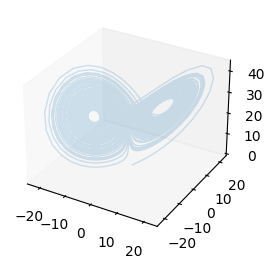

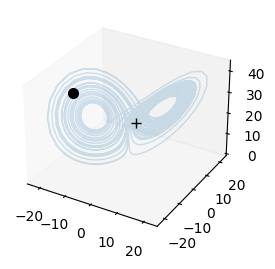

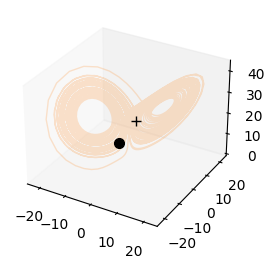

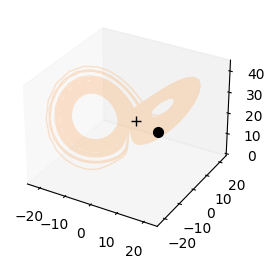

In [11]:
datas = [ds_train, ds_test, ds_est_WD, ds_est_WR]
colors = ["tab:blue", "tab:blue", "tab:orange", "tab:orange"]
names = ["ds_train", "ds_test", "ds_est_WD", "ds_est_WR"]
for i, data in enumerate(datas):
    pl.figure(figsize=(3,3))
    ax = pl.subplot(projection="3d")
    ax.plot(data[0, :], data[1, :], data[2, :], lw=1, alpha=0.2, color=colors[i])
    if i > 0:
        ax.plot(data[0, 0], data[1, 0], data[2, 0], "k+", markersize=7)
        ax.plot(data[0, -1], data[1, -1], data[2, -1], "ko", markersize=7)
    ax.set_xlim([-25,25])
    ax.set_ylim([-25,25])
    ax.set_zlim([-1,45])
    ax.grid(False)
    pl.savefig(figdir+str(ismp)+"-"+names[i]+".pdf", bbox_inches='tight')

print( "|WD - WR| = ", Fnorm(WD - WR) )
print( "|pinv(A)@A - I| = ", Fnorm(pinv(A)@A - np.eye(nin)) )
print( "|pinv(A)@(Bh - B) - [pinv(A)@Bh - pinv(A)@B)] | = ", Fnorm( pinv(A)@(Bh - B) - (pinv(A)@Bh - pinv(A)@B) ) )
print( "|tanh( arctanh(R) ) - R | = ", Fnorm( sig(arcsig(rs)) - rs ) )
print( "|R@pinv(R) - I| = ", Fnorm(rs@pinv(rs) - np.eye(nr)) )

## Avarage numerical errors

In [7]:
WDvWRs = np.zeros(nsmp)
Ainvs = np.zeros(nsmp)
dists = np.zeros(nsmp)
tanhinvs = np.zeros(nsmp)
Rinvs = np.zeros(nsmp)


for ismp in range(nsmp):
    A, B, g, rs, WD, WR, Bh = results[ismp]
    WDvWRs[ismp] = np.sqrt( Fnorm(WD - WR) )
    Ainvs[ismp] = np.sqrt( Fnorm(pinv(A)@A - np.eye(nin)) )
    dists[ismp] = np.sqrt( Fnorm( pinv(A)@(Bh - B) - (pinv(A)@Bh - pinv(A)@B) ) )
    tanhinvs[ismp] = np.sqrt( Fnorm( sig(arcsig(rs)) - rs ) )
    Rinvs[ismp] = np.sqrt( Fnorm(rs@pinv(rs) - np.eye(nr)) )
    
    
print( "|WD - WR| = ", WDvWRs.min(), WDvWRs.max() )
print( "|pinv(A)@A - I| = ", Ainvs.min(), Ainvs.max() )
print( "|pinv(A)@(Bh - B) - [pinv(A)@Bh - pinv(A)@B)] | = ", dists.min(), dists.max() )
print( "|tanh( arctanh(R) ) - R | = ", tanhinvs.min(), tanhinvs.max() )
print( "|R@pinv(R) - I| = ", Rinvs.min(), Rinvs.max() )


|WD - WR| =  0.01044828204280854 0.02664589565846712
|pinv(A)@A - I| =  3.3897757345730626e-16 1.8085102837973636e-15
|pinv(A)@(Bh - B) - [pinv(A)@Bh - pinv(A)@B)] | =  1.3392690300425106e-14 1.5989639525468105e-14
|tanh( arctanh(R) ) - R | =  3.495934140290632e-14 3.6408608604741374e-14
|R@pinv(R) - I| =  4.958390409685045e-11 2.961743106665766e-10
